In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

import numpy as np
import pandas as pd
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer


/home/mrahm/anaconda3/envs/mlproject/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
df1 = pd.read_csv('play_store_facebook_reviews_with_sentiment_full.csv')
df1.drop(columns=['Score'], inplace=True)
df1['Category'] = df1['Category'].replace('good', 1)
df1['Category'] = df1['Category'].replace('bad', 0)


df2 = pd.read_csv('app_store_facebook_reviews_with_sentiment_full.csv')
df2.drop(columns=['Score'], inplace=True)
df2['Category'] = df2['Category'].replace('good', 1)
df2['Category'] = df2['Category'].replace('bad', 0)

In [42]:
facebook_features = ['messenger', 'newsfeed', 'photos', 'song', 'video', 'back', 'button', 'gaming', 'marketplace', 'notification', 'menu', 'reels',
                     'story', 'cover', 'cover photo', 'profile', 'friend', 'event', 'timeline', 'groups', 'status', 'save', 'posts', 'like', 'comments',
                    'share', 'reacts', 'privacy', 'album', 'login', 'signup', 'register', 'pages', 'ad', 'advertisement', 'dating', 'memory', 'message']
print(facebook_features)

['messenger', 'newsfeed', 'photos', 'song', 'video', 'back', 'button', 'gaming', 'marketplace', 'notification', 'menu', 'reels', 'story', 'cover', 'cover photo', 'profile', 'friend', 'event', 'timeline', 'groups', 'status', 'save', 'posts', 'like', 'comments', 'share', 'reacts', 'privacy', 'album', 'login', 'signup', 'register', 'pages', 'ad', 'advertisement', 'dating']


In [17]:
df = pd.concat([df1, df2], ignore_index=True)
df.shape

(16020, 2)

In [20]:
df = df[df['Category'] != 'neutral']
unique_values_counts = df['Category'].value_counts()
unique_values_counts

0    13977
1     1128
Name: Category, dtype: int64

<h2>1. Preprocessing Starts for Classification<h2>

In [22]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk import pos_tag
import re

# Download NLTK resources (uncomment the following two lines if you haven't downloaded them before)
nltk.download('stopwords')
nltk.download('punkt')

# Function for text preprocessing
def preprocess_text(review):
    # Convert to lowercase
    review = review.lower()

    # Remove URLs
    review = re.sub(r'https?://\S+|www\.\S+', '', review)

    # Remove emojis
    review = review.encode('ascii', 'ignore').decode('ascii')

    # Remove punctuation, apostrophes, and quotes
    review = re.sub(r"[^a-zA-Z\s]", '', review)


    
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    review = emoji_pattern.sub(r'', review)
    
    
    # removing apostrophe 's from words in the text
    review = re.sub(r'\'s\s', ' ', review)
    # omitting other apostrophes
    review = re.sub(r'\'', '', review)

    # removing Emails
    review = re.sub(r'\S*@\S*\s?', '', review)


    # removing distracting single quotes
    review = re.sub(r"\'", "", review)
    
    # Tokenize
    words = word_tokenize(review)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word.lower() not in stop_words]

    # Stemming
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]

    # POS tagging and keep only nouns, adjectives, verbs, and adverbs
    pos_tags = pos_tag(words)
    words = [word for word, pos in pos_tags if pos.startswith(('N', 'J', 'V', 'R'))]

    return words

# Apply preprocessing and create a new column 'content_processed'
df['content_processed'] = df['Review'].apply(preprocess_text)

# Display the processed DataFrame
print(df)

[nltk_data] Downloading package stopwords to /home/mrahm/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/mrahm/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                                                  Review Category  \
0      Ridiculous update -- the Back button no longer...        0   
1      Since the most recent update, the backup arrow...        0   
2      This app is so unreliable. This has happened w...        0   
3      Edit: Cool, so instead of fixing the existing ...        0   
4      Y'all took away my ability to use my phone's b...        0   
...                                                  ...      ...   
16015  Just last week I could edit my post on my phon...        0   
16016  My mom passed in May and I submitted 2 request...        0   
16017  This app is trashiest. Facebook has no rules t...        0   
16018  This app is trash!! Y’all are so sensitive 🤬 I...        0   
16019  Literally no excuses. This is a gigantic compa...        0   

                                       content_processed  
0      [ridicul, updat, back, button, longer, work, u...  
1      [sinc, recent, updat, backup, arrow, work, pho

/home/mrahm/anaconda3/envs/mlproject/lib/python3.6/site-packages/ipykernel_launcher.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [25]:
df['content_processed']

0        [ridicul, updat, back, button, longer, work, u...
1        [sinc, recent, updat, backup, arrow, work, pho...
2        [app, unreli, happen, way, mani, time, get, ne...
3        [edit, cool, instead, fix, exist, back, button...
4        [yall, took, away, abil, use, phone, back, but...
                               ...                        
16015    [last, week, edit, post, phone, forgot, someth...
16016    [mom, pass, submit, request, account, track, r...
16017    [app, trashiest, facebook, rule, make, sinc, a...
16018    [app, trash, yall, sensit, keep, get, repriman...
16019    [liter, excus, gigant, compani, fix, adher, ac...
Name: content_processed, Length: 15105, dtype: object

In [30]:
df['content_processed'] = df['content_processed'].astype(str).str.replace(r'\[|\]|,', '', regex=True)
df['content_processed'] = df['content_processed'].str.replace("'", "")

/home/mrahm/anaconda3/envs/mlproject/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/mrahm/anaconda3/envs/mlproject/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [36]:
df.rename(columns={'content_processed': 'Review'}, inplace=True)

/home/mrahm/anaconda3/envs/mlproject/lib/python3.6/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [37]:
df.head

<bound method NDFrame.head of       Category                                             Review
0            0  ridicul updat back button longer work use face...
1            0  sinc recent updat backup arrow work phone im u...
2            0  app unreli happen way mani time get new updat ...
3            0  edit cool instead fix exist back button issu a...
4            0  yall took away abil use phone back button bott...
...        ...                                                ...
16015        0  last week edit post phone forgot someth misspe...
16016        0  mom pass submit request account track request ...
16017        0  app trashiest facebook rule make sinc allow ra...
16018        0  app trash yall sensit keep get reprimand guy p...
16019        0  liter excus gigant compani fix adher accur acc...

[15105 rows x 2 columns]>

In [50]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [51]:
df.to_csv('final_data.csv', index = False)

<h4>Preprocessing ends for Classification<h4>

<h2>2. Classification Starts<h2>

<h4>2.1 SVM<h4>

In [3]:
import pandas as pd
df = pd.read_csv('final_data.csv')
df.columns

Index(['Category', 'Review'], dtype='object')

C = 0.5: Training Loss - 1.0246146922645785, Validation Loss - 1.0427163875823457, Test Accuracy: 0.941747572815534
C = 1: Training Loss - 1.0024401438419603, Validation Loss - 1.0320195456398344, Test Accuracy: 0.9488084730803178
C = 5: Training Loss - 0.9542532474671601, Validation Loss - 1.0194839114277818, Test Accuracy: 0.9373345101500441
C = 10: Training Loss - 0.9414695904894332, Validation Loss - 1.0219436637521384, Test Accuracy: 0.9324801412180053
C = 20: Training Loss - 0.9332727182104119, Validation Loss - 1.0270904301715917, Test Accuracy: 0.9232127096204766
C = 50: Training Loss - 0.9274112335224871, Validation Loss - 1.040285997254177, Test Accuracy: 0.910414827890556
C = 100: Training Loss - 0.926364359789048, Validation Loss - 1.047406166955802, Test Accuracy: 0.9029126213592233
C = 1000: Training Loss - 0.9260446943310189, Validation Loss - 1.0507430678440173, Test Accuracy: 0.8984995586937334


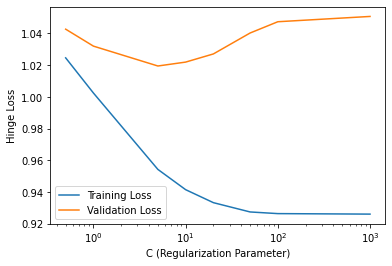

In [7]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

# Load your dataset (replace 'your_dataset.csv' with your actual file)

# Split the dataset into features (X) and labels (y)
X = df['Review']
y = df['Category']

# Step 1: Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Step 2: Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

C_values = [0.5, 1, 5, 10, 20, 50, 100, 1000]

svm_model = SVC(kernel='linear', random_state=42)

num_epochs = 1
# Lists to store training and validation loss for each epoch
train_losses = []
val_losses = []

# Training loop for different values of C
for C_value in C_values:
    # Train an SVM model with the current C value
    svm_model = SVC(kernel='linear', C=C_value, random_state=42)
    svm_model.fit(X_train_tfidf, y_train)

    # Calculate hinge loss for training set
    train_hinge_loss = np.maximum(0, 1 - y_train * svm_model.decision_function(X_train_tfidf))
    train_average_hinge_loss = train_hinge_loss.mean()
    train_losses.append(train_average_hinge_loss)

    # Calculate hinge loss for validation set
    val_hinge_loss = np.maximum(0, 1 - y_val * svm_model.decision_function(X_val_tfidf))
    val_average_hinge_loss = val_hinge_loss.mean()
    val_losses.append(val_average_hinge_loss)
    # Evaluate on the test set after training
    test_predictions = svm_model.predict(X_test_tfidf)
    test_accuracy = accuracy_score(y_test, test_predictions)
    test_confusion_matrix = confusion_matrix(y_test, test_predictions)
    print(f"C = {C_value}: Training Loss - {train_average_hinge_loss}, Validation Loss - {val_average_hinge_loss}, Test Accuracy: {test_accuracy}")
    
    


# Plot the training and validation losses for different C values
plt.plot(C_values, train_losses, label='Training Loss')
plt.plot(C_values, val_losses, label='Validation Loss')
plt.xscale('log')  # Use a logarithmic scale for better visualization
plt.xlabel('C (Regularization Parameter)')
plt.ylabel('Hinge Loss')
plt.legend()
plt.savefig('SVM: loss_vs_C.png')
plt.show()




<h4>2.2 Logistic Regression<h4>

In [1]:
import pandas as pd
df = pd.read_csv('final_data.csv')

/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 1/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 2/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 3/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 4/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 5/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 6/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 7/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 8/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 9/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 10/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 11/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 12/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 13/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 14/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 15/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 16/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 17/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 18/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 19/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 20/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 21/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 26/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 27/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 28/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 29/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 30/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 31/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 32/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 33/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 34/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 35/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 36/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 37/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 38/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 39/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 40/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 41/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 42/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 43/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 44/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 45/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 46/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 47/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 48/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 49/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 50/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 51/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 52/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 53/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 54/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 55/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 56/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 57/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 58/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 59/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 60/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 61/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 62/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 63/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 64/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 65/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 66/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 67/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 68/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 69/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 70/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 71/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 72/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 73/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 74/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 75/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 76/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 77/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 78/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 79/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 80/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 81/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 82/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 83/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 84/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 85/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 86/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 87/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 88/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 89/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 90/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 91/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 92/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 93/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 94/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 95/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 96/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 97/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 98/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 99/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 100/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 101/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 102/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 103/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 104/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 105/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 106/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 107/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 108/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 109/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 110/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 111/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 112/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 113/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 114/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 115/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 116/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 117/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 118/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 119/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 120/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 121/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 122/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 123/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 124/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 125/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 126/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 127/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 128/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 129/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 130/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 131/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 132/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 133/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 134/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 135/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 136/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 137/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 138/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 139/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 140/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 141/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 142/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 143/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 144/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 145/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 146/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 147/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 148/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 149/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 150/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 151/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 152/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 153/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 154/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 155/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 156/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 157/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 158/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 159/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 160/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 161/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 162/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 163/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 164/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 165/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 166/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 167/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 168/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 169/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 170/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 171/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 172/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 173/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 174/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 175/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 176/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 177/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 178/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 179/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 180/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 181/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 182/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 183/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 184/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 185/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 186/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 187/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 188/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 189/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 190/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 191/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 192/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 193/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 194/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 195/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 196/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 197/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 198/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 199/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 200/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 201/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 202/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 203/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 204/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 205/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 206/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 207/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 208/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 209/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 210/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 211/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 212/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 213/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 214/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 215/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 216/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 217/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 218/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 219/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 220/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 221/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 222/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 223/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 224/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 225/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 226/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 227/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 228/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 229/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 230/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 231/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 232/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 233/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 234/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 235/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 236/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 237/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 238/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 239/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 240/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 241/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 242/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 243/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 244/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 245/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 246/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 247/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 248/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 249/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 250/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 251/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 252/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 253/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 254/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 255/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 256/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 257/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 258/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 259/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 260/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 261/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 262/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 263/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 264/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 265/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 266/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 267/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 268/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 269/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 270/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 271/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 272/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 273/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 274/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 275/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 276/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 277/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 278/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 279/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 280/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 281/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 282/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 283/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 284/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 285/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 286/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 287/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 288/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 289/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 290/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 291/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 292/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 293/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 294/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 295/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 296/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 297/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 298/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 299/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 300/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 301/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 302/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 303/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 304/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 305/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 306/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 307/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 308/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 309/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 310/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 311/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 312/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 313/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 314/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 315/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 316/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 317/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 318/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 319/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 320/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 321/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 322/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 323/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 324/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 325/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 326/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 327/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 328/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 329/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 330/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 331/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 332/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 333/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 334/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 335/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 336/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 337/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 338/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 339/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 340/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 341/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 342/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 343/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 344/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 345/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 346/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 347/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 348/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 349/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 350/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 351/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 352/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 353/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 354/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 355/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 356/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 357/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 358/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 359/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 360/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 361/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 362/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 363/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 364/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 365/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 366/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 367/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 368/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 369/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 370/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 371/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 372/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 373/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 374/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 375/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 376/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 377/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 378/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 379/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 380/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 381/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 382/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 383/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 384/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 385/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 386/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 387/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 388/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 389/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 390/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 391/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 392/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 393/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 394/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 395/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 396/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 397/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 398/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 399/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 400/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 401/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 402/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 403/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 404/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 405/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 406/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 407/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 408/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 409/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 410/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 411/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 412/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 413/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 414/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 415/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 416/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 417/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 418/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 419/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 420/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 421/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 422/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 423/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 424/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 425/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 426/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 427/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 428/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 429/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 430/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 431/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 432/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 433/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 434/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 435/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 436/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 437/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 438/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 439/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 440/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 441/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 442/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 443/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 444/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 445/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 446/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 447/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 448/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 449/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 450/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 451/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 452/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 453/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 454/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 455/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 456/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 457/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 458/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 459/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 460/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 461/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 462/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 463/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 464/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 465/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 466/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 467/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 468/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 469/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 470/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 471/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 472/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 473/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 474/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 475/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 476/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 477/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 478/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 479/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 480/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 481/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 482/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 483/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 484/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 485/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 486/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 487/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 488/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 489/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 490/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 491/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 492/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 493/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 494/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Epoch 495/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 496/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 497/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 498/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 499/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 500/500 - Train Loss: 0.2604, Val Loss: 0.2689, Test Loss: 0.2642, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


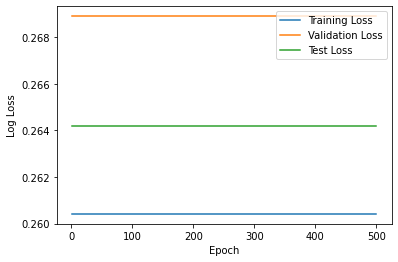

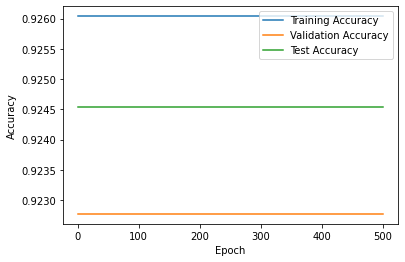

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
import matplotlib.pyplot as plt


# Split the dataset into features (X) and labels (y)
X = df['Review']
y = df['Category']

# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

# Initialize logistic regression model
logreg_model = LogisticRegression(max_iter=1, random_state=42, solver='lbfgs')

# Number of epochs
num_epochs = 500

# Lists to store training, validation, and test loss, accuracy for each epoch
train_losses = []
val_losses = []
test_losses = []
train_accuracies = []
val_accuracies = []
test_accuracies = []

# Training loop for multiple epochs
for epoch in range(num_epochs):
    # Fit the model on the training set for one epoch
    logreg_model.fit(X_train_tfidf, y_train)

    # Predictions and log loss for training set
    train_predictions = logreg_model.predict(X_train_tfidf)
    train_loss = log_loss(y_train, logreg_model.predict_proba(X_train_tfidf)[:, 1])
    train_accuracy = accuracy_score(y_train, train_predictions)

    # Predictions and log loss for validation set
    val_predictions = logreg_model.predict(X_val_tfidf)
    val_loss = log_loss(y_val, logreg_model.predict_proba(X_val_tfidf)[:, 1])
    val_accuracy = accuracy_score(y_val, val_predictions)

    # Predictions and log loss for test set
    test_predictions = logreg_model.predict(X_test_tfidf)
    test_loss = log_loss(y_test, logreg_model.predict_proba(X_test_tfidf)[:, 1])
    test_accuracy = accuracy_score(y_test, test_predictions)

    # Append values to lists
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    test_accuracies.append(test_accuracy)

    # Print progress
    print(f"Epoch {epoch + 1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}, "
          f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}, Test Acc: {test_accuracy:.4f}")

# Plot training, validation, and test loss
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.legend()
plt.savefig('Log Reg: epoch_vs_loss.png')
plt.show()

# Plot training, validation, and test accuracy
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('Log Reg: epoch_vs_accuracy.png')
plt.show()

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss

# Assuming you have already loaded your dataset into a DataFrame 'df'

# Split the dataset into features (X) and labels (y)
X = df['Review']
y = df['Category']

# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

# Define the logistic regression model
logreg_model = LogisticRegression(random_state=42, solver='lbfgs')

# Define the hyperparameters to search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter': [100, 500, 1000],
    'solver': ['lbfgs', 'liblinear'],
    'class_weight': [None, 'balanced'],
    'penalty': ['l1', 'l2']
}

# Create the GridSearchCV object
grid_search = GridSearchCV(logreg_model, param_grid, cv=5, scoring='accuracy', verbose=1)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train_tfidf, y_train)

# Print the best parameters and their corresponding accuracy
print("Best Parameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)

# Use the best model for predictions on the validation set
best_model = grid_search.best_estimator_
val_predictions = best_model.predict(X_val_tfidf)
val_accuracy = accuracy_score(y_val, val_predictions)
print("Validation Accuracy with Best Model: ", val_accuracy)


Fitting 5 folds for each of 144 candidates, totalling 720 fits


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Best Parameters:  {'C': 10, 'class_weight': None, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Accuracy:  0.9455217608155471
Validation Accuracy with Best Model:  0.9430714916151809


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


/home/mrahm/anaconda3/envs/mlproject/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 1/500 - Train Loss: 0.6943, Val Loss: 0.6924, Test Loss: 0.6924, Train Acc: 0.3302, Val Acc: 0.6174, Test Acc: 0.6041
Epoch 2/500 - Train Loss: 0.6925, Val Loss: 0.6905, Test Loss: 0.6905, Train Acc: 0.6033, Val Acc: 0.8354, Test Acc: 0.8314
Epoch 3/500 - Train Loss: 0.6906, Val Loss: 0.6887, Test Loss: 0.6887, Train Acc: 0.8221, Val Acc: 0.9064, Test Acc: 0.9095
Epoch 4/500 - Train Loss: 0.6887, Val Loss: 0.6868, Test Loss: 0.6868, Train Acc: 0.9087, Val Acc: 0.9210, Test Acc: 0.9241
Epoch 5/500 - Train Loss: 0.6868, Val Loss: 0.6850, Test Loss: 0.6850, Train Acc: 0.9246, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 6/500 - Train Loss: 0.6850, Val Loss: 0.6831, Test Loss: 0.6831, Train Acc: 0.9259, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 7/500 - Train Loss: 0.6832, Val Loss: 0.6813, Test Loss: 0.6813, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 8/500 - Train Loss: 0.6813, Val Loss: 0.6795, Test Loss: 0.6795, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 9/

Epoch 71/500 - Train Loss: 0.5831, Val Loss: 0.5826, Test Loss: 0.5821, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 72/500 - Train Loss: 0.5818, Val Loss: 0.5813, Test Loss: 0.5808, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 73/500 - Train Loss: 0.5805, Val Loss: 0.5800, Test Loss: 0.5795, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 74/500 - Train Loss: 0.5792, Val Loss: 0.5787, Test Loss: 0.5782, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 75/500 - Train Loss: 0.5779, Val Loss: 0.5775, Test Loss: 0.5769, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 76/500 - Train Loss: 0.5766, Val Loss: 0.5762, Test Loss: 0.5756, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 77/500 - Train Loss: 0.5753, Val Loss: 0.5749, Test Loss: 0.5744, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 78/500 - Train Loss: 0.5740, Val Loss: 0.5737, Test Loss: 0.5731, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


Epoch 141/500 - Train Loss: 0.5052, Val Loss: 0.5058, Test Loss: 0.5049, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 142/500 - Train Loss: 0.5042, Val Loss: 0.5049, Test Loss: 0.5040, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 143/500 - Train Loss: 0.5033, Val Loss: 0.5040, Test Loss: 0.5030, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 144/500 - Train Loss: 0.5024, Val Loss: 0.5031, Test Loss: 0.5021, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 145/500 - Train Loss: 0.5015, Val Loss: 0.5022, Test Loss: 0.5012, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 146/500 - Train Loss: 0.5006, Val Loss: 0.5013, Test Loss: 0.5003, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 147/500 - Train Loss: 0.4997, Val Loss: 0.5004, Test Loss: 0.4994, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 148/500 - Train Loss: 0.4988, Val Loss: 0.4995, Test Loss: 0.4985, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc:

Epoch 211/500 - Train Loss: 0.4497, Val Loss: 0.4513, Test Loss: 0.4500, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 212/500 - Train Loss: 0.4490, Val Loss: 0.4506, Test Loss: 0.4493, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 213/500 - Train Loss: 0.4484, Val Loss: 0.4499, Test Loss: 0.4486, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 214/500 - Train Loss: 0.4477, Val Loss: 0.4493, Test Loss: 0.4480, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 215/500 - Train Loss: 0.4470, Val Loss: 0.4487, Test Loss: 0.4473, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 216/500 - Train Loss: 0.4464, Val Loss: 0.4480, Test Loss: 0.4467, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 217/500 - Train Loss: 0.4457, Val Loss: 0.4474, Test Loss: 0.4460, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 218/500 - Train Loss: 0.4451, Val Loss: 0.4467, Test Loss: 0.4454, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc:

Epoch 281/500 - Train Loss: 0.4094, Val Loss: 0.4117, Test Loss: 0.4101, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 282/500 - Train Loss: 0.4089, Val Loss: 0.4113, Test Loss: 0.4096, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 283/500 - Train Loss: 0.4084, Val Loss: 0.4108, Test Loss: 0.4092, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 284/500 - Train Loss: 0.4080, Val Loss: 0.4103, Test Loss: 0.4087, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 285/500 - Train Loss: 0.4075, Val Loss: 0.4098, Test Loss: 0.4082, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 286/500 - Train Loss: 0.4070, Val Loss: 0.4094, Test Loss: 0.4077, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 287/500 - Train Loss: 0.4065, Val Loss: 0.4089, Test Loss: 0.4072, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 288/500 - Train Loss: 0.4060, Val Loss: 0.4084, Test Loss: 0.4068, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc:

Epoch 351/500 - Train Loss: 0.3796, Val Loss: 0.3825, Test Loss: 0.3806, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 352/500 - Train Loss: 0.3792, Val Loss: 0.3822, Test Loss: 0.3803, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 353/500 - Train Loss: 0.3789, Val Loss: 0.3818, Test Loss: 0.3799, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 354/500 - Train Loss: 0.3785, Val Loss: 0.3814, Test Loss: 0.3796, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 355/500 - Train Loss: 0.3781, Val Loss: 0.3811, Test Loss: 0.3792, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 356/500 - Train Loss: 0.3778, Val Loss: 0.3807, Test Loss: 0.3788, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 357/500 - Train Loss: 0.3774, Val Loss: 0.3804, Test Loss: 0.3785, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 358/500 - Train Loss: 0.3771, Val Loss: 0.3800, Test Loss: 0.3781, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc:

Epoch 421/500 - Train Loss: 0.3571, Val Loss: 0.3605, Test Loss: 0.3584, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 422/500 - Train Loss: 0.3568, Val Loss: 0.3602, Test Loss: 0.3581, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 423/500 - Train Loss: 0.3565, Val Loss: 0.3600, Test Loss: 0.3579, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 424/500 - Train Loss: 0.3563, Val Loss: 0.3597, Test Loss: 0.3576, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 425/500 - Train Loss: 0.3560, Val Loss: 0.3594, Test Loss: 0.3573, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 426/500 - Train Loss: 0.3557, Val Loss: 0.3592, Test Loss: 0.3570, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 427/500 - Train Loss: 0.3554, Val Loss: 0.3589, Test Loss: 0.3568, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 428/500 - Train Loss: 0.3552, Val Loss: 0.3586, Test Loss: 0.3565, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc:

Epoch 491/500 - Train Loss: 0.3398, Val Loss: 0.3437, Test Loss: 0.3414, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 492/500 - Train Loss: 0.3396, Val Loss: 0.3434, Test Loss: 0.3411, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 493/500 - Train Loss: 0.3394, Val Loss: 0.3432, Test Loss: 0.3409, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 494/500 - Train Loss: 0.3391, Val Loss: 0.3430, Test Loss: 0.3407, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 495/500 - Train Loss: 0.3389, Val Loss: 0.3428, Test Loss: 0.3405, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 496/500 - Train Loss: 0.3387, Val Loss: 0.3426, Test Loss: 0.3403, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 497/500 - Train Loss: 0.3385, Val Loss: 0.3424, Test Loss: 0.3401, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 498/500 - Train Loss: 0.3383, Val Loss: 0.3422, Test Loss: 0.3399, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc:

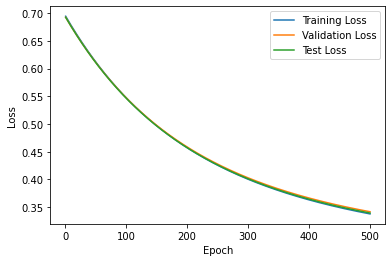

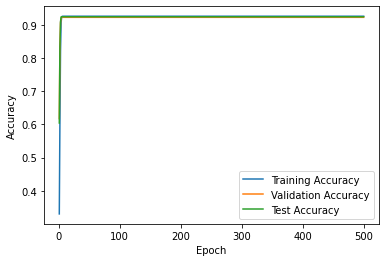

In [12]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Define a custom logistic regression class
class CustomLogisticRegression(nn.Module):
    def __init__(self, input_size):
        super(CustomLogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))


# Split the dataset into features (X) and labels (y)
X = df['Review']
y = df['Category']

# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

# Convert the data to PyTorch tensors
X_train_tensor = Variable(torch.Tensor(X_train_tfidf.toarray()))
y_train_tensor = Variable(torch.Tensor(y_train.values).view(-1, 1))
X_val_tensor = Variable(torch.Tensor(X_val_tfidf.toarray()))
y_val_tensor = Variable(torch.Tensor(y_val.values).view(-1, 1))
X_test_tensor = Variable(torch.Tensor(X_test_tfidf.toarray()))
y_test_tensor = Variable(torch.Tensor(y_test.values).view(-1, 1))

# Initialize the custom logistic regression model
input_size = X_train_tfidf.shape[1]
model = CustomLogisticRegression(input_size)

# Define the loss function (you can replace this with your custom loss function)
criterion = nn.BCELoss()

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Number of epochs
num_epochs = 500

# Lists to store training, validation, and test loss, accuracy for each epoch
train_losses = []
val_losses = []
test_losses = []
train_accuracies = []
val_accuracies = []
test_accuracies = []

# Training loop for multiple epochs
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Evaluate on training set
    with torch.no_grad():
        train_predictions = (outputs > 0.5).float()
        train_accuracy = accuracy_score(y_train_tensor.numpy(), train_predictions.numpy())
        train_losses.append(loss.item())
        train_accuracies.append(train_accuracy)

    # Evaluate on validation set
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        val_predictions = (val_outputs > 0.5).float()
        val_accuracy = accuracy_score(y_val_tensor.numpy(), val_predictions.numpy())
        val_losses.append(val_loss.item())
        val_accuracies.append(val_accuracy)

    # Evaluate on test set
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_loss = criterion(test_outputs, y_test_tensor)
        test_predictions = (test_outputs > 0.5).float()
        test_accuracy = accuracy_score(y_test_tensor.numpy(), test_predictions.numpy())
        test_losses.append(test_loss.item())
        test_accuracies.append(test_accuracy)

    # Print progress
    print(f"Epoch {epoch + 1}/{num_epochs} - "
          f"Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Test Loss: {test_loss.item():.4f}, "
          f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}, Test Acc: {test_accuracy:.4f}")

# Plot training, validation, and test loss
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Log Reg(NN-BCEloss): epoch_vs_loss.png')
plt.show()

# Plot training, validation, and test accuracy
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('Log Reg(NN-BCEloss): epoch_vs_accuracy.png')
plt.show()


Epoch 1/500 - Train Loss: 0.5017, Val Loss: 0.5012, Test Loss: 0.5013, Train Acc: 0.1186, Val Acc: 0.1871, Test Acc: 0.1792
Epoch 2/500 - Train Loss: 0.5013, Val Loss: 0.5008, Test Loss: 0.5008, Train Acc: 0.1828, Val Acc: 0.2767, Test Acc: 0.2763
Epoch 3/500 - Train Loss: 0.5008, Val Loss: 0.5003, Test Loss: 0.5003, Train Acc: 0.2784, Val Acc: 0.4082, Test Acc: 0.4007
Epoch 4/500 - Train Loss: 0.5003, Val Loss: 0.4998, Test Loss: 0.4999, Train Acc: 0.4058, Val Acc: 0.5560, Test Acc: 0.5543
Epoch 5/500 - Train Loss: 0.4998, Val Loss: 0.4994, Test Loss: 0.4994, Train Acc: 0.5545, Val Acc: 0.6880, Test Acc: 0.6849
Epoch 6/500 - Train Loss: 0.4994, Val Loss: 0.4989, Test Loss: 0.4989, Train Acc: 0.6874, Val Acc: 0.7873, Test Acc: 0.7855
Epoch 7/500 - Train Loss: 0.4989, Val Loss: 0.4984, Test Loss: 0.4984, Train Acc: 0.7907, Val Acc: 0.8548, Test Acc: 0.8557
Epoch 8/500 - Train Loss: 0.4984, Val Loss: 0.4980, Test Loss: 0.4980, Train Acc: 0.8628, Val Acc: 0.8950, Test Acc: 0.8985
Epoch 9/

Epoch 71/500 - Train Loss: 0.4688, Val Loss: 0.4686, Test Loss: 0.4685, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 72/500 - Train Loss: 0.4684, Val Loss: 0.4681, Test Loss: 0.4680, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 73/500 - Train Loss: 0.4679, Val Loss: 0.4677, Test Loss: 0.4676, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 74/500 - Train Loss: 0.4674, Val Loss: 0.4672, Test Loss: 0.4671, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 75/500 - Train Loss: 0.4670, Val Loss: 0.4668, Test Loss: 0.4666, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 76/500 - Train Loss: 0.4665, Val Loss: 0.4663, Test Loss: 0.4662, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 77/500 - Train Loss: 0.4660, Val Loss: 0.4658, Test Loss: 0.4657, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 78/500 - Train Loss: 0.4656, Val Loss: 0.4654, Test Loss: 0.4652, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


Epoch 137/500 - Train Loss: 0.4385, Val Loss: 0.4385, Test Loss: 0.4382, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 138/500 - Train Loss: 0.4380, Val Loss: 0.4380, Test Loss: 0.4378, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 139/500 - Train Loss: 0.4376, Val Loss: 0.4376, Test Loss: 0.4373, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 140/500 - Train Loss: 0.4371, Val Loss: 0.4371, Test Loss: 0.4369, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 141/500 - Train Loss: 0.4367, Val Loss: 0.4367, Test Loss: 0.4364, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 142/500 - Train Loss: 0.4362, Val Loss: 0.4362, Test Loss: 0.4360, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 143/500 - Train Loss: 0.4358, Val Loss: 0.4358, Test Loss: 0.4355, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 144/500 - Train Loss: 0.4353, Val Loss: 0.4354, Test Loss: 0.4351, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc:

Epoch 205/500 - Train Loss: 0.4085, Val Loss: 0.4087, Test Loss: 0.4084, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 206/500 - Train Loss: 0.4081, Val Loss: 0.4083, Test Loss: 0.4079, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 207/500 - Train Loss: 0.4076, Val Loss: 0.4079, Test Loss: 0.4075, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 208/500 - Train Loss: 0.4072, Val Loss: 0.4075, Test Loss: 0.4071, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 209/500 - Train Loss: 0.4068, Val Loss: 0.4070, Test Loss: 0.4066, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 210/500 - Train Loss: 0.4064, Val Loss: 0.4066, Test Loss: 0.4062, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 211/500 - Train Loss: 0.4059, Val Loss: 0.4062, Test Loss: 0.4058, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 212/500 - Train Loss: 0.4055, Val Loss: 0.4058, Test Loss: 0.4054, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc:

Epoch 275/500 - Train Loss: 0.3795, Val Loss: 0.3800, Test Loss: 0.3795, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 276/500 - Train Loss: 0.3791, Val Loss: 0.3796, Test Loss: 0.3791, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 277/500 - Train Loss: 0.3787, Val Loss: 0.3792, Test Loss: 0.3787, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 278/500 - Train Loss: 0.3783, Val Loss: 0.3788, Test Loss: 0.3783, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 279/500 - Train Loss: 0.3779, Val Loss: 0.3784, Test Loss: 0.3779, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 280/500 - Train Loss: 0.3775, Val Loss: 0.3780, Test Loss: 0.3775, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 281/500 - Train Loss: 0.3771, Val Loss: 0.3776, Test Loss: 0.3771, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 282/500 - Train Loss: 0.3767, Val Loss: 0.3772, Test Loss: 0.3767, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc:

Epoch 342/500 - Train Loss: 0.3538, Val Loss: 0.3545, Test Loss: 0.3539, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 343/500 - Train Loss: 0.3535, Val Loss: 0.3542, Test Loss: 0.3535, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 344/500 - Train Loss: 0.3531, Val Loss: 0.3538, Test Loss: 0.3532, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 345/500 - Train Loss: 0.3527, Val Loss: 0.3534, Test Loss: 0.3528, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 346/500 - Train Loss: 0.3524, Val Loss: 0.3531, Test Loss: 0.3524, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 347/500 - Train Loss: 0.3520, Val Loss: 0.3527, Test Loss: 0.3521, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 348/500 - Train Loss: 0.3516, Val Loss: 0.3523, Test Loss: 0.3517, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 349/500 - Train Loss: 0.3513, Val Loss: 0.3520, Test Loss: 0.3513, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc:

Epoch 408/500 - Train Loss: 0.3307, Val Loss: 0.3316, Test Loss: 0.3309, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 409/500 - Train Loss: 0.3304, Val Loss: 0.3312, Test Loss: 0.3305, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 410/500 - Train Loss: 0.3300, Val Loss: 0.3309, Test Loss: 0.3302, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 411/500 - Train Loss: 0.3297, Val Loss: 0.3306, Test Loss: 0.3299, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 412/500 - Train Loss: 0.3294, Val Loss: 0.3303, Test Loss: 0.3295, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 413/500 - Train Loss: 0.3290, Val Loss: 0.3299, Test Loss: 0.3292, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 414/500 - Train Loss: 0.3287, Val Loss: 0.3296, Test Loss: 0.3289, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 415/500 - Train Loss: 0.3284, Val Loss: 0.3293, Test Loss: 0.3285, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc:

Epoch 475/500 - Train Loss: 0.3094, Val Loss: 0.3105, Test Loss: 0.3097, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 476/500 - Train Loss: 0.3091, Val Loss: 0.3102, Test Loss: 0.3094, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 477/500 - Train Loss: 0.3088, Val Loss: 0.3099, Test Loss: 0.3091, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 478/500 - Train Loss: 0.3085, Val Loss: 0.3096, Test Loss: 0.3088, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 479/500 - Train Loss: 0.3082, Val Loss: 0.3093, Test Loss: 0.3085, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 480/500 - Train Loss: 0.3079, Val Loss: 0.3090, Test Loss: 0.3082, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 481/500 - Train Loss: 0.3076, Val Loss: 0.3087, Test Loss: 0.3079, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 482/500 - Train Loss: 0.3073, Val Loss: 0.3084, Test Loss: 0.3076, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc:

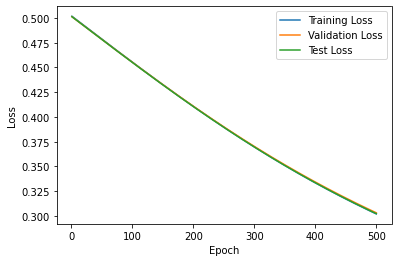

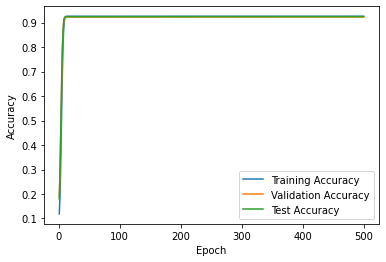

In [13]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Define a custom loss function
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, y_pred, y_true):
        # Your custom loss calculation
        loss = torch.mean(torch.abs(y_pred - y_true))  # Example: Mean absolute error
        return loss

# Define a custom logistic regression class
class CustomLogisticRegression(nn.Module):
    def __init__(self, input_size):
        super(CustomLogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

# Split the dataset into features (X) and labels (y)
X = df['Review']
y = df['Category']

# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

# Convert the data to PyTorch tensors
X_train_tensor = Variable(torch.Tensor(X_train_tfidf.toarray()))
y_train_tensor = Variable(torch.Tensor(y_train.values).view(-1, 1))
X_val_tensor = Variable(torch.Tensor(X_val_tfidf.toarray()))
y_val_tensor = Variable(torch.Tensor(y_val.values).view(-1, 1))
X_test_tensor = Variable(torch.Tensor(X_test_tfidf.toarray()))
y_test_tensor = Variable(torch.Tensor(y_test.values).view(-1, 1))

# Initialize the custom logistic regression model
input_size = X_train_tfidf.shape[1]
model = CustomLogisticRegression(input_size)

# Define the custom loss function
custom_loss = CustomLoss()

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Number of epochs
num_epochs = 500

# Lists to store training, validation, and test loss, accuracy for each epoch
train_losses = []
val_losses = []
test_losses = []
train_accuracies = []
val_accuracies = []
test_accuracies = []

# Training loop for multiple epochs
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = custom_loss(outputs, y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Evaluate on training set
    with torch.no_grad():
        train_predictions = (outputs > 0.5).float()
        train_accuracy = accuracy_score(y_train_tensor.numpy(), train_predictions.numpy())
        train_losses.append(loss.item())
        train_accuracies.append(train_accuracy)

    # Evaluate on validation set
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = custom_loss(val_outputs, y_val_tensor)
        val_predictions = (val_outputs > 0.5).float()
        val_accuracy = accuracy_score(y_val_tensor.numpy(), val_predictions.numpy())
        val_losses.append(val_loss.item())
        val_accuracies.append(val_accuracy)

    # Evaluate on test set
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_loss = custom_loss(test_outputs, y_test_tensor)
        test_predictions = (test_outputs > 0.5).float()
        test_accuracy = accuracy_score(y_test_tensor.numpy(), test_predictions.numpy())
        test_losses.append(test_loss.item())
        test_accuracies.append(test_accuracy)

    # Print progress
    print(f"Epoch {epoch + 1}/{num_epochs} - "
          f"Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Test Loss: {test_loss.item():.4f}, "
          f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}, Test Acc: {test_accuracy:.4f}")

# Plot training, validation, and test loss
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Log Reg(NN-MAEloss): epoch_vs_loss.png')
plt.show()

# Plot training, validation, and test accuracy
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('Log Reg(NN-MAEloss): epoch_vs_accuracy.png')
plt.show()

Epoch 1/500 - Train Loss: 0.4742, Val Loss: 0.4732, Test Loss: 0.4731, Train Acc: 0.1186, Val Acc: 0.2123, Test Acc: 0.2154
Epoch 2/500 - Train Loss: 0.4732, Val Loss: 0.4721, Test Loss: 0.4721, Train Acc: 0.2145, Val Acc: 0.3857, Test Acc: 0.3919
Epoch 3/500 - Train Loss: 0.4721, Val Loss: 0.4711, Test Loss: 0.4710, Train Acc: 0.3880, Val Acc: 0.6117, Test Acc: 0.6218
Epoch 4/500 - Train Loss: 0.4710, Val Loss: 0.4700, Test Loss: 0.4700, Train Acc: 0.6073, Val Acc: 0.7899, Test Acc: 0.7886
Epoch 5/500 - Train Loss: 0.4700, Val Loss: 0.4690, Test Loss: 0.4689, Train Acc: 0.7876, Val Acc: 0.8839, Test Acc: 0.8835
Epoch 6/500 - Train Loss: 0.4689, Val Loss: 0.4679, Test Loss: 0.4679, Train Acc: 0.8832, Val Acc: 0.9144, Test Acc: 0.9148
Epoch 7/500 - Train Loss: 0.4679, Val Loss: 0.4669, Test Loss: 0.4668, Train Acc: 0.9176, Val Acc: 0.9223, Test Acc: 0.9232
Epoch 8/500 - Train Loss: 0.4668, Val Loss: 0.4658, Test Loss: 0.4658, Train Acc: 0.9252, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 9/

Epoch 71/500 - Train Loss: 0.4087, Val Loss: 0.4084, Test Loss: 0.4080, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 72/500 - Train Loss: 0.4079, Val Loss: 0.4076, Test Loss: 0.4072, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 73/500 - Train Loss: 0.4071, Val Loss: 0.4068, Test Loss: 0.4064, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 74/500 - Train Loss: 0.4063, Val Loss: 0.4060, Test Loss: 0.4056, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 75/500 - Train Loss: 0.4055, Val Loss: 0.4052, Test Loss: 0.4049, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 76/500 - Train Loss: 0.4047, Val Loss: 0.4044, Test Loss: 0.4041, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 77/500 - Train Loss: 0.4039, Val Loss: 0.4036, Test Loss: 0.4033, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 78/500 - Train Loss: 0.4031, Val Loss: 0.4028, Test Loss: 0.4025, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245


Epoch 141/500 - Train Loss: 0.3592, Val Loss: 0.3595, Test Loss: 0.3589, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 142/500 - Train Loss: 0.3586, Val Loss: 0.3589, Test Loss: 0.3583, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 143/500 - Train Loss: 0.3580, Val Loss: 0.3583, Test Loss: 0.3577, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 144/500 - Train Loss: 0.3574, Val Loss: 0.3577, Test Loss: 0.3571, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 145/500 - Train Loss: 0.3568, Val Loss: 0.3571, Test Loss: 0.3565, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 146/500 - Train Loss: 0.3562, Val Loss: 0.3565, Test Loss: 0.3559, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 147/500 - Train Loss: 0.3556, Val Loss: 0.3560, Test Loss: 0.3554, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 148/500 - Train Loss: 0.3550, Val Loss: 0.3554, Test Loss: 0.3548, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc:

Epoch 211/500 - Train Loss: 0.3218, Val Loss: 0.3227, Test Loss: 0.3219, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 212/500 - Train Loss: 0.3214, Val Loss: 0.3222, Test Loss: 0.3214, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 213/500 - Train Loss: 0.3209, Val Loss: 0.3218, Test Loss: 0.3210, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 214/500 - Train Loss: 0.3205, Val Loss: 0.3213, Test Loss: 0.3205, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 215/500 - Train Loss: 0.3200, Val Loss: 0.3209, Test Loss: 0.3201, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 216/500 - Train Loss: 0.3195, Val Loss: 0.3204, Test Loss: 0.3196, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 217/500 - Train Loss: 0.3191, Val Loss: 0.3200, Test Loss: 0.3192, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 218/500 - Train Loss: 0.3186, Val Loss: 0.3195, Test Loss: 0.3187, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc:

Epoch 281/500 - Train Loss: 0.2934, Val Loss: 0.2947, Test Loss: 0.2937, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 282/500 - Train Loss: 0.2930, Val Loss: 0.2943, Test Loss: 0.2933, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 283/500 - Train Loss: 0.2927, Val Loss: 0.2940, Test Loss: 0.2930, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 284/500 - Train Loss: 0.2923, Val Loss: 0.2936, Test Loss: 0.2926, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 285/500 - Train Loss: 0.2919, Val Loss: 0.2933, Test Loss: 0.2923, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 286/500 - Train Loss: 0.2916, Val Loss: 0.2929, Test Loss: 0.2919, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 287/500 - Train Loss: 0.2913, Val Loss: 0.2926, Test Loss: 0.2916, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 288/500 - Train Loss: 0.2909, Val Loss: 0.2922, Test Loss: 0.2912, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc:

Epoch 351/500 - Train Loss: 0.2714, Val Loss: 0.2731, Test Loss: 0.2719, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 352/500 - Train Loss: 0.2711, Val Loss: 0.2728, Test Loss: 0.2716, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 353/500 - Train Loss: 0.2709, Val Loss: 0.2725, Test Loss: 0.2714, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 354/500 - Train Loss: 0.2706, Val Loss: 0.2723, Test Loss: 0.2711, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 355/500 - Train Loss: 0.2703, Val Loss: 0.2720, Test Loss: 0.2708, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 356/500 - Train Loss: 0.2700, Val Loss: 0.2717, Test Loss: 0.2706, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 357/500 - Train Loss: 0.2698, Val Loss: 0.2715, Test Loss: 0.2703, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 358/500 - Train Loss: 0.2695, Val Loss: 0.2712, Test Loss: 0.2700, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc:

Epoch 421/500 - Train Loss: 0.2542, Val Loss: 0.2562, Test Loss: 0.2549, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 422/500 - Train Loss: 0.2540, Val Loss: 0.2560, Test Loss: 0.2547, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 423/500 - Train Loss: 0.2538, Val Loss: 0.2558, Test Loss: 0.2545, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 424/500 - Train Loss: 0.2536, Val Loss: 0.2556, Test Loss: 0.2543, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 425/500 - Train Loss: 0.2534, Val Loss: 0.2554, Test Loss: 0.2541, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 426/500 - Train Loss: 0.2532, Val Loss: 0.2552, Test Loss: 0.2539, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 427/500 - Train Loss: 0.2529, Val Loss: 0.2549, Test Loss: 0.2537, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 428/500 - Train Loss: 0.2527, Val Loss: 0.2547, Test Loss: 0.2534, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc:

Epoch 491/500 - Train Loss: 0.2406, Val Loss: 0.2429, Test Loss: 0.2415, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 492/500 - Train Loss: 0.2405, Val Loss: 0.2427, Test Loss: 0.2413, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 493/500 - Train Loss: 0.2403, Val Loss: 0.2425, Test Loss: 0.2411, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 494/500 - Train Loss: 0.2401, Val Loss: 0.2424, Test Loss: 0.2410, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 495/500 - Train Loss: 0.2399, Val Loss: 0.2422, Test Loss: 0.2408, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 496/500 - Train Loss: 0.2398, Val Loss: 0.2420, Test Loss: 0.2406, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 497/500 - Train Loss: 0.2396, Val Loss: 0.2419, Test Loss: 0.2404, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc: 0.9245
Epoch 498/500 - Train Loss: 0.2394, Val Loss: 0.2417, Test Loss: 0.2403, Train Acc: 0.9260, Val Acc: 0.9228, Test Acc:

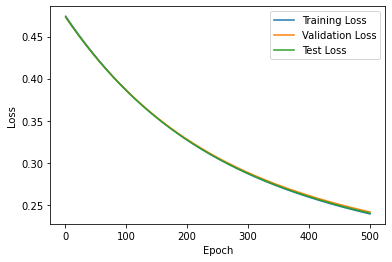

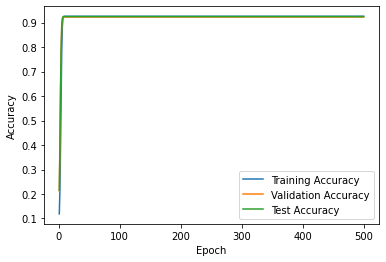

In [14]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Define a custom loss function with BCE and MSE
class CustomLoss(nn.Module):
    def __init__(self, weight_bce=0.5, weight_mse=0.5):
        super(CustomLoss, self).__init__()
        self.weight_bce = weight_bce
        self.weight_mse = weight_mse
        self.bce_loss = nn.BCELoss()
        self.mse_loss = nn.MSELoss()

    def forward(self, y_pred, y_true):
        bce_loss = self.bce_loss(y_pred, y_true)
        mse_loss = self.mse_loss(y_pred, y_true)

        # Combine BCE and MSE losses
        loss = self.weight_bce * bce_loss + self.weight_mse * mse_loss
        return loss

# Define a custom logistic regression class
class CustomLogisticRegression(nn.Module):
    def __init__(self, input_size):
        super(CustomLogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

# Function to train a model with a given loss function
def train_model(model, criterion, optimizer, X_train, y_train, X_val, y_val, num_epochs=500):
    input_size = X_train.shape[1]

    # Convert the data to PyTorch tensors
    X_train_tensor = Variable(torch.Tensor(X_train))
    y_train_tensor = Variable(torch.Tensor(y_train.values).view(-1, 1))
    X_val_tensor = Variable(torch.Tensor(X_val))
    y_val_tensor = Variable(torch.Tensor(y_val.values).view(-1, 1))

    # Lists to store training and validation loss for each epoch
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Forward pass
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Evaluate on training set
        with torch.no_grad():
            train_losses.append(loss.item())

        # Evaluate on validation set
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor)
            val_losses.append(val_loss.item())

    return train_losses, val_losses


# Split the dataset into features (X) and labels (y)
X = df['Review']
y = df['']

# Apply SMOTE to handle imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X.values.reshape(-1, 1), y)

# Split the resampled data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train.flatten())
X_val_tfidf = vectorizer.transform(X_val.flatten())
X_test_tfidf = vectorizer.transform(X_test.flatten())

# Initialize the custom logistic regression model
input_size = X_train_tfidf.shape[1]
model = CustomLogisticRegression(input_size)

# Define the custom loss function
custom_loss = CustomLoss(weight_bce=1.0, weight_mse=1.0)

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Number of epochs
num_epochs = 500

# Train the model and collect losses
train_losses, val_losses = train_model(model, custom_loss, optimizer, X_train_tfidf.toarray(), y_train, X_val_tfidf.toarray(), y_val, num_epochs=num_epochs)

# Plot training and validation loss
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Training model with BCE Loss
Training model with MAE Loss
Training model with MSE Loss
Training model with Custom Combined Loss


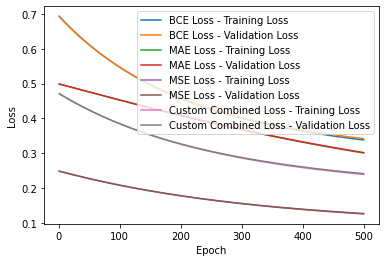

In [10]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

df = pd.read_csv('final_data.csv')


# Define a custom loss function as a combination of MSE and BCE
class CombinedLoss(nn.Module):
    def __init__(self, weight_mse=0.5, weight_bce=0.5):
        super(CombinedLoss, self).__init__()
        self.weight_mse = weight_mse
        self.weight_bce = weight_bce
        self.mse_loss = nn.MSELoss()
        self.bce_loss = nn.BCELoss()

    def forward(self, y_pred, y_true):
        mse_loss = self.mse_loss(y_pred, y_true)
        bce_loss = self.bce_loss(y_pred, y_true)
        combined_loss = self.weight_mse * mse_loss + self.weight_bce * bce_loss
        return combined_loss

# Define a custom logistic regression class
class CustomLogisticRegression(nn.Module):
    def __init__(self, input_size):
        super(CustomLogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

# Function to train a model with a given loss function
def train_model(model, criterion, optimizer, X_train, y_train, X_val, y_val, num_epochs=500):
    input_size = X_train.shape[1]

    # Convert the data to PyTorch tensors
    X_train_tensor = Variable(torch.Tensor(X_train))
    y_train_tensor = Variable(torch.Tensor(y_train.values).view(-1, 1))
    X_val_tensor = Variable(torch.Tensor(X_val))
    y_val_tensor = Variable(torch.Tensor(y_val.values).view(-1, 1))

    # Lists to store training and validation loss for each epoch
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Forward pass
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Evaluate on training set
        with torch.no_grad():
            train_losses.append(loss.item())

        # Evaluate on validation set
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor)
            val_losses.append(val_loss.item())

    return train_losses, val_losses


# Split the dataset into features (X) and labels (y)
X = df['Review']
y = df['Category']

# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

# Initialize models
models = {
    'BCE Loss': CustomLogisticRegression(X_train_tfidf.shape[1]),
    'MAE Loss': CustomLogisticRegression(X_train_tfidf.shape[1]),
    'MSE Loss': CustomLogisticRegression(X_train_tfidf.shape[1]),
    'Custom Combined Loss': CustomLogisticRegression(X_train_tfidf.shape[1]),
}

# Define optimizers and loss functions for each model
optimizers = {name: optim.SGD(model.parameters(), lr=0.01) for name, model in models.items()}
criterion_bce = nn.BCELoss()
criterion_mae = nn.L1Loss()
criterion_mse = torch.nn.MSELoss()
criterion_custom = CombinedLoss(weight_mse=0.5, weight_bce=0.5)

# Train models and collect losses
all_losses = {}

for model_name, model in models.items():
    print(f"Training model with {model_name}")
    if model_name == 'BCE Loss':
        criterion = criterion_bce
    elif model_name == 'MAE Loss':
        criterion = criterion_mae
    elif model_name == 'MSE Loss':
        criterion = criterion_mse
    else:
        criterion = criterion_custom

    optimizer = optimizers[model_name]
    train_losses, val_losses = train_model(model, criterion, optimizer, X_train_tfidf.toarray(), y_train, X_val_tfidf.toarray(), y_val)
    all_losses[model_name] = {'train_losses': train_losses, 'val_losses': val_losses}

# Plot training and validation loss for each model
for model_name, losses in all_losses.items():
    plt.plot(range(1, num_epochs + 1), losses['train_losses'], label=f'{model_name} - Training Loss')
    plt.plot(range(1, num_epochs + 1), losses['val_losses'], label=f'{model_name} - Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('x Log Reg(NN-All): epoch_vs_loss.png')
plt.show()


<h5>Using SMOTE since the dataset is highly imbalanced<h5>
    @article{chawla2002smote,
  title={SMOTE: synthetic minority over-sampling technique},
  author={Chawla, Nitesh V and Bowyer, Kevin W and Hall, Lawrence O and Kegelmeyer, W Philip},
  journal={Journal of artificial intelligence research},
  volume={16},
  pages={321--357},
  year={2002}
}

In [5]:
!pip install imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 14.4 MB/s eta 0:00:00


In [6]:
!pip install pandas scikit-learn imbalanced-learn

In [36]:
df = pd.read_csv('final_data.csv')
df.columns

Index(['Category', 'Review'], dtype='object')

<h5>Logistic Regression from Sklearn Module with SMOTE<h5>

In [50]:
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Assuming you have a list of texts (X) and corresponding labels (y)
# Replace X and y with your actual data

# Example:
X = df['Review']
y = df['Category']  # 1 for positive, 0 for negative

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Specify the desired ratio for the minority class oversampling
# In this case, we want to oversample the minority class by a factor of 10
sampling_strategy = 0.2

# Convert text data to numerical features using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Apply SMOTE to oversample the minority class
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_tfidf, y_train)

# Print the number of samples before and after SMOTE
print(f"Number of samples before SMOTE: {len(y_train)}")
print(f"Number of samples after SMOTE: {len(y_resampled)}")

# Train a classifier on the resampled data
clf = LogisticRegression(random_state=42)
clf.fit(X_resampled, y_resampled)

# Convert the test set to TF-IDF
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Make predictions on the test set
y_pred = clf.predict(X_test_tfidf)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Number of samples before SMOTE: 12084
Number of samples after SMOTE: 13419
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2794
           1       0.78      0.38      0.51       227

    accuracy                           0.95      3021
   macro avg       0.87      0.69      0.74      3021
weighted avg       0.94      0.95      0.94      3021

Accuracy: 0.9457133399536577


<h5>Vanilla Logistic Regression from Sklearn Module<h5>

In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Assuming you have a DataFrame 'df' with columns 'text' and 'label'
# Replace 'your_dataframe' with your actual DataFrame name

# Split the data into features (X) and labels (y)
X = df['Review']
y = df['Category']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize the text data using CountVectorizer
vectorizer = CountVectorizer()
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

# Train logistic regression model
model = LogisticRegression()
model.fit(X_train_vect, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_vect)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{class_report}')


Accuracy: 0.9417411453161205
Confusion Matrix:
[[2744   50]
 [ 126  101]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2794
           1       0.67      0.44      0.53       227

    accuracy                           0.94      3021
   macro avg       0.81      0.71      0.75      3021
weighted avg       0.93      0.94      0.94      3021



/home/mrahm/anaconda3/envs/mlproject/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [7]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Assuming you have a DataFrame 'df' with columns 'Review' and 'Category'
X = df['Review']
y = df['Category']  # 1 for positive, 0 for negative

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Specify the desired ratio for the minority class oversampling
# In this case, we want to oversample the minority class by a factor of 10
sampling_strategy = 0.2

# Convert text data to numerical features using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Apply SMOTE to oversample the minority class
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_tfidf, y_train)

# Print the number of samples before and after SMOTE
print(f"Number of samples before SMOTE: {len(y_train)}")
print(f"Number of samples after SMOTE: {len(y_resampled)}")

# Define the logistic regression model
logreg_model = LogisticRegression(random_state=42)

# Define the hyperparameters to search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter': [100, 500, 1000],
    'solver': ['lbfgs', 'liblinear'],
    'class_weight': [None, 'balanced'],
    'penalty': ['l1', 'l2']
}

# Create the GridSearchCV object
grid_search = GridSearchCV(logreg_model, param_grid, cv=5, scoring='accuracy', verbose=1)

# Fit the GridSearchCV object to the resampled data
grid_search.fit(X_resampled, y_resampled)

# Print the best parameters and their corresponding accuracy
print("Best Parameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)

# Use the best model for predictions on the test set
best_model = grid_search.best_estimator_
X_test_tfidf = tfidf_vectorizer.transform(X_test)
y_pred = best_model.predict(X_test_tfidf)

# Evaluate the model on the test set
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Number of samples before SMOTE: 12084
Number of samples after SMOTE: 13419
Fitting 5 folds for each of 144 candidates, totalling 720 fits


/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mrahm/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Best Parameters:  {'C': 100, 'class_weight': None, 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Accuracy:  0.9592376907536717
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2794
           1       0.53      0.51      0.52       227

    accuracy                           0.93      3021
   macro avg       0.74      0.73      0.74      3021
weighted avg       0.93      0.93      0.93      3021

Accuracy: 0.9285004965243296


<h4>2.3 Roberta-Large<h4>

In [54]:
import pandas as pd
df = pd.read_csv('final_data.csv')
df.columns

Index(['Category', 'Review'], dtype='object')

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt



# Split the dataset into train, validation, and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

# Tokenize the text data
tokenizer = RobertaTokenizer.from_pretrained('roberta-large')
train_encodings = tokenizer(list(train_df['Review']), truncation=True, padding=True, max_length=256, return_tensors='pt')
val_encodings = tokenizer(list(val_df['Review']), truncation=True, padding=True, max_length=256, return_tensors='pt')
test_encodings = tokenizer(list(test_df['Review']), truncation=True, padding=True, max_length=256, return_tensors='pt')

# Create custom dataset
class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = CustomDataset(train_encodings, list(train_df['Category']))
val_dataset = CustomDataset(val_encodings, list(val_df['Category']))
test_dataset = CustomDataset(test_encodings, list(test_df['Category']))

# Initialize RoBERTa model
model = RobertaForSequenceClassification.from_pretrained('roberta-large')

# Initialize optimizer and criterion
optimizer = AdamW(model.parameters(), lr=1e-5)
criterion = torch.nn.CrossEntropyLoss()

# Create DataLoader for training, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Training loop
num_epochs = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Training loop
num_epochs = 3
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        _, predicted = outputs.logits.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    train_accuracy = correct_train / total_train
    train_losses.append(epoch_train_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    epoch_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            epoch_val_loss += loss.item()
            _, predicted = outputs.logits.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

    val_accuracy = correct_val / total_val
    val_losses.append(epoch_val_loss / len(val_loader))
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Testing
model.eval()
test_predictions = []
test_labels = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        _, predicted_labels = torch.max(logits, 1)
        test_predictions.extend(predicted_labels.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# Calculate test accuracy
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f'Test Accuracy: {test_accuracy}')

# Plotting
plt.figure(figsize=(12, 4))

# Loss plots
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plots
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


<h2>LDA and feature mapping has been performed on LDA.ipynb file<h2>